# Decadal Omega Aragonite Velocity (21st Century)
# (Surface irr 0.1 W/m^2)

In [1]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature

In [2]:
%matplotlib inline

In [3]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## RCP85 Ensemble Average

In [4]:
# irr0.1 Omega Arag for ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Omega_Arag/RCP85/'
filename = 'omega_arag_irr_0.1Wm2_ensAvg_1950_2100.nc'
oa_path = directory+filename
ds = xr.open_dataset(oa_path).rename({'XT_OCEAN': 'xt_ocean',
                                     'YT_OCEAN': 'yt_ocean',
                                     'TIME': 'time',
                                     'OMEGA_ARAG_IRR': 'omega_arag'})

## Grid calculations

In [5]:
# default behavior is to extrapolite grid position to the left
ds_full = xgcm.generate_grid_ds(ds, {'X':'xt_ocean', 'Y':'yt_ocean'})

In [6]:
# Create grid object (periodic along X-axis)
grid = xgcm.Grid(ds_full, periodic=['X'], 
                 coords={'X': {'center': 'xt_ocean', 'left': 'xt_ocean_left'},
                         'Y': {'center': 'yt_ocean', 'left': 'yt_ocean_left'},
                         'T': {'center': 'time'}})

In [7]:
# Compute cartesian distances
grid_calculations(grid, ds_full)

---

## Decadal Mean Omega Arag

In [8]:
# Calculate the time-mean Omega Arag for 10 decades of simulation
# 2000s through 2090s labeled 0-9
da_oa_annual = ds_full.omega_arag.groupby('time.year').mean(dim='time', skipna=True)
da_oa_mean = []

decade = 2000
for i in range(10):
    dec_mean = decadal_mean(da_oa_annual, decade)
    da_oa_mean.append(dec_mean)
    decade += 10

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/common.py:671: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  return self._groupby_cls(
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


---

## Zonal Gradient of Mean Omega Arag (ºC / km)

In [9]:
# Compute zonal (along x-axis) gradient of irr0.1 Omega Arag
doa_dx = []
for i in range(10):
    x_grad = grid.diff(da_oa_mean[i], 'X', boundary='fill', 
                       fill_value=np.nan) / (ds_full.dxg / 1000).squeeze()
    doa_dx.append(x_grad)

## Meridional Gradient Omega Arag (ºC / km)

In [10]:
# Compute meridional (along y-axis) gradient of irr0.1 Omega Arag
doa_dy = []
for i in range(10):
    y_grad = grid.diff(da_oa_mean[i], 'Y', boundary='fill',
                       fill_value=np.nan) / (ds_full.dyg / 1000).squeeze()
    # Flip direction in southern hemisphere so directions are poleward
    y_grad[0:90] = -y_grad[0:90]
    doa_dy.append(y_grad)

## Gradient Magnitude of Omega Arag (ºC / km)

In [11]:
# Calculate magnitude of spatial gradients
# Create datasets for each decade
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data
doa_ds = []
for i in range(10):
    dx2 = np.square(doa_dx[i]).data
    dy2 = np.square(doa_dy[i]).data
    grad = np.sqrt(dx2+dy2)
    gradient = xr.DataArray(grad, dims=['yt_ocean','xt_ocean'], coords=[lat,lon])
    doa_ds.append(gradient)

### Regular Plot

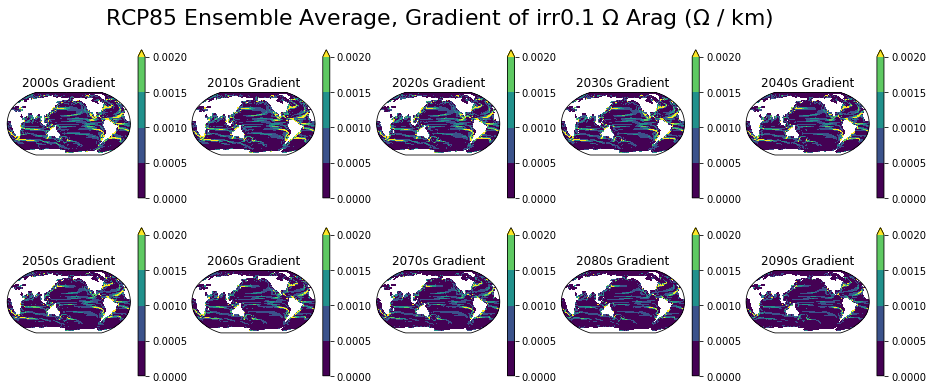

In [12]:
# Plot Omega Arag gradient for each decade
crs = ccrs.Robinson(central_longitude=180)
src=ccrs.PlateCarree()
nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6],
                               subplot_kw={'projection':crs})

decade = 2000
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        clevs = np.arange(0, 2.01e-3, 5e-4)
        doa_ds[row*5 + col].plot(ax=ax, levels=clevs, transform=src, robust=True)
        ax.set_title(str(decade)+'s Gradient')
        ax.set_global()
        decade += 10

fig.suptitle('RCP85 Ensemble Average, Gradient of irr0.1 $\Omega$ Arag ($\Omega$ / km)',
            fontsize=22)
fig.savefig("./oa_vel_10figs/oa_gradient_decadal_10")

### Latitudinal Mean Gradient

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/

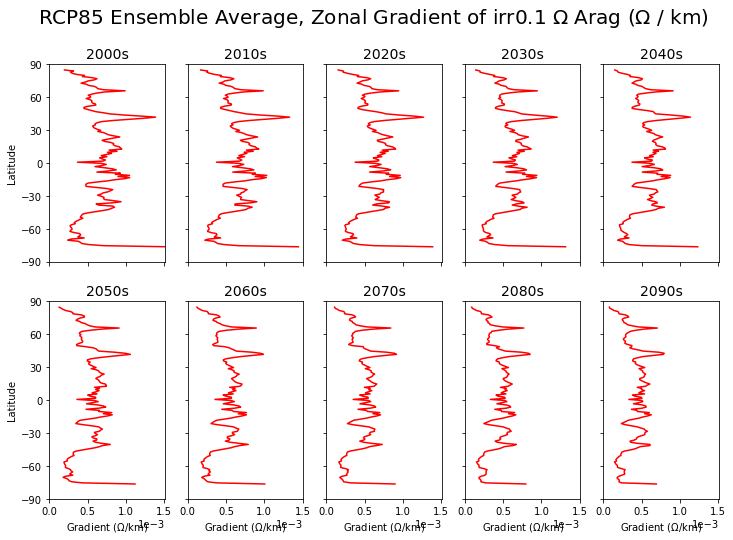

In [13]:
# Plot latitudinal mean zonal irr0.1 Omega Arag gradient
nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,8], 
                        sharex=True, sharey=True)

decade = 2000
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        i = row*5 + col
        X = doa_ds[i].mean(dim='xt_ocean', skipna=True).squeeze()[5:175]
        Y = doa_ds[i]['yt_ocean'][5:175]
        ax.plot(X,Y,'r')
        ax.set_title(str(decade)+'s',loc='center',fontsize=14)
        ax.set_ylim(-90,90)
        ax.set_xlim(0,1.51e-3)
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Gradient ($\Omega$/km)')
        ax.set_yticks(np.arange(-90,91,30))
        ax.set_xticks(np.arange(0,1.51e-3,5e-4))
        # Only label outer axes
        ax.label_outer()
        ax.ticklabel_format(axis='x', style='sci', scilimits=[0,0])

        decade += 10

fig.suptitle('RCP85 Ensemble Average, Zonal Gradient of irr0.1 $\Omega$ Arag ($\Omega$ / km)',
            fontsize=20)
fig.savefig("./oa_vel_10figs/oa_gradient_stats_10")

### Contour Plot

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


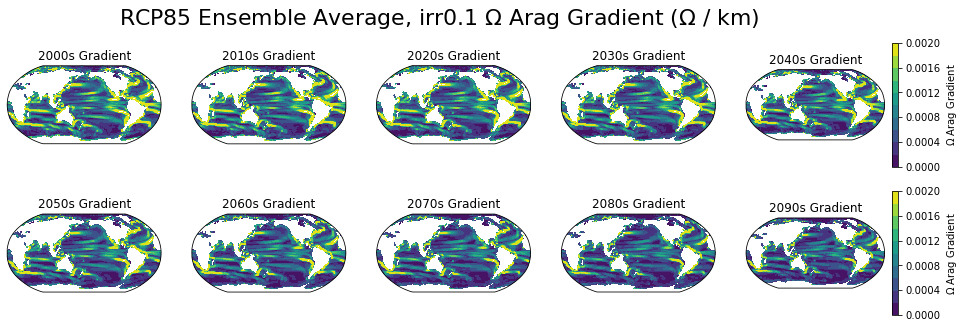

In [14]:
# Plot Omega Arag gradient for each decade -- Contour Plot
crs = ccrs.Robinson(central_longitude=180)
src=ccrs.PlateCarree()
nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,5],
                               subplot_kw={'projection':crs})

decade = 2000
clevs = np.arange(0, 2.1e-3, 2e-4)
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        i = row*5 + col
        im = ax.contourf(lon,lat,doa_ds[i].data,levels=clevs, 
                         transform=src, robust=True)
        ax.set_title(str(decade)+'s Gradient')
        if col==ncols-1:
            cbar = plt.colorbar(im,ax=ax,orientation='vertical',fraction=0.05,pad=0.05)
            cbar.set_label('$\Omega$ Arag Gradient')
        decade += 10

fig.suptitle('RCP85 Ensemble Average, irr0.1 $\Omega$ Arag Gradient ($\Omega$ / km)',
            fontsize=22)
fig.savefig("./oa_vel_10figs/oa_gradient_decadal_10")

---

## irr0.1 Omega Arag Change

### Decadal Omega Arag Change (ºC / decade)

### Calculate Using Linear Regression (best model)

In [15]:
# If Datasets are already saved
decade = 2000
doa_dt = []
for i in range(10):
    oa_path = './delta_omega_arag_irr/'+str(decade)+'s'
    da_decade = xr.open_dataarray(oa_path).T
    doa_dt.append(da_decade)
    decade+=10

### Regular Plot

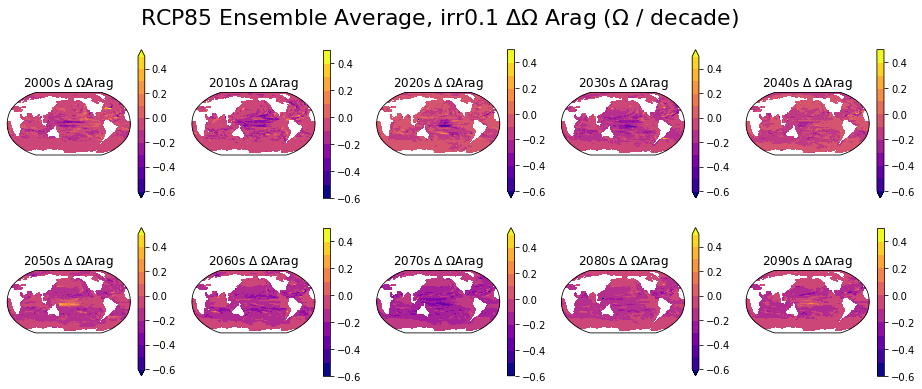

In [16]:
# Plot decadal Omega Arag change using best-fit linear model
crs = ccrs.Robinson(central_longitude=180)
nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6],
                               subplot_kw={'projection':crs})

decade = 2000
clevs=np.arange(-0.6,0.6,0.1)
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        doa_dt[row*5+col].plot(ax=ax, cmap='plasma', levels=clevs,
                      transform=ccrs.PlateCarree(), robust=True)
        ax.set_title(str(decade)+'s $\Delta$ $\Omega$Arag')
        decade+=10

fig.suptitle('RCP85 Ensemble Average, irr0.1 $\Delta$$\Omega$ Arag ($\Omega$ / decade)',
            fontsize=22)
fig.savefig("./oa_vel_10figs/oa_change_decadal_10")

### Contour Plot

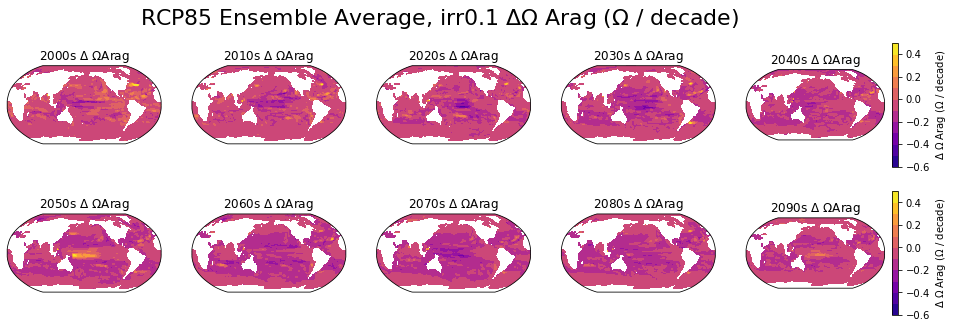

In [17]:
# Plot decadal Omega Arag change using best-fit linear model
nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,5],
                               subplot_kw={'projection':crs})

decade = 2000
# clevs=[-1.0, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4]
clevs = np.arange(-0.6, 0.6, 0.1)
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        i = row*5 + col
        im = ax.contourf(lon,lat, doa_dt[i], levels=clevs, cmap='plasma',
                         transform=src, robust=True)
        ax.set_title(str(decade)+'s $\Delta$ $\Omega$Arag')
        if col==ncols-1:
            cbar = plt.colorbar(im,ax=ax,orientation='vertical',fraction=0.05,pad=0.05)
            cbar.set_label('$\Delta$ $\Omega$ Arag ($\Omega$ / decade)')
        decade+=10

fig.suptitle('RCP85 Ensemble Average, irr0.1 $\Delta$$\Omega$ Arag ($\Omega$ / decade)',
            fontsize=22)
fig.savefig("./oa_vel_10figs/oa_change_decadal_10")

### Latitudinal Mean Omega Arag Change

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/

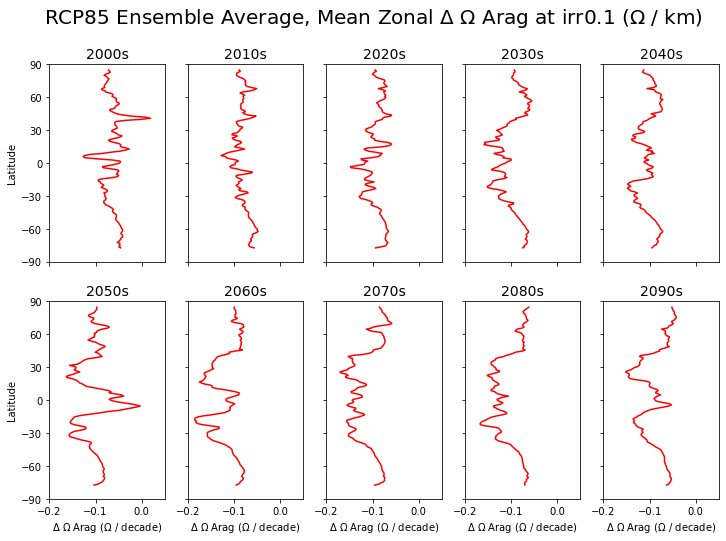

In [18]:
# Plot latitudinal mean zonal irr0.1 Omega Arag Change
nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,8], 
                        sharex=True, sharey=True)

decade = 2000
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        i = row*5 + col
        X = doa_dt[i].mean(dim='xt_ocean', skipna=True).squeeze()[5:175]
        Y = doa_dt[i]['yt_ocean'][5:175]
        ax.plot(X,Y,'r')
        ax.set_title(str(decade)+'s',loc='center',fontsize=14)
        ax.set_ylim(-90,90)
        ax.set_xlim(-0.2, 0.05)
        ax.set_yticks(np.arange(-90,91,30))
        ax.set_xticks(np.arange(-0.2, 0.05, 0.1))
        ax.set_ylabel('Latitude')
        ax.set_xlabel('$\Delta$ $\Omega$ Arag ($\Omega$ / decade)')
        # Only label outer axes
        ax.label_outer()
        decade += 10
        

fig.suptitle('RCP85 Ensemble Average, Mean Zonal $\Delta$ $\Omega$ Arag at irr0.1 ($\Omega$ / km)',
            fontsize=20)
fig.savefig("./oa_vel_10figs/oa_change_stats_10")

---

## Zonal k01 Omega Arag Velocity (km/decade)

In [19]:
# Calculate zonal Omega Arag velocity
# Using linear regression over each decade for Omega Arag change over time,
# and time-mean decadal Omega Arag for spatial gradient
x_velocity = []
for i in range(10):
    dOA_dt = doa_dt[i].squeeze().T.data
    dOA_dx = doa_dx[i].squeeze().T.data
    x_vel = dOA_dt/dOA_dx

    # Create DataArray
    x_vel = xr.DataArray(x_vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    x_vel = x_vel.where(x_vel.loc[:,:] < np.inf)
    x_velocity.append(x_vel)

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()
<ipython-input-19-4fde45925f6b>:8: RuntimeWarning: divide by zero encountered in true_divide
  x_vel = dOA_dt/dOA_dx


## Meridional Omega Arag Velocity (km/decade)

In [20]:
# Calculate meridional Omega Arag velocity
# Using linear regression over each decade for Omega Arag change over time,
# and time-mean decadal Omega Arag for spatial gradient
y_velocity = []
for i in range(10):
    dOA_dt = doa_dt[i].squeeze().T.data
    dOA_dy = doa_dy[i].squeeze().T.data
    y_vel = dOA_dt/dOA_dy

    # Create DataArray
    y_vel = xr.DataArray(y_vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    y_vel = y_vel.where(y_vel.loc[:,:] != np.inf)
    y_velocity.append(y_vel)

<ipython-input-20-88471d1031d0>:8: RuntimeWarning: divide by zero encountered in true_divide
  y_vel = dOA_dt/dOA_dy
<ipython-input-20-88471d1031d0>:8: RuntimeWarning: divide by zero encountered in true_divide
  y_vel = dOA_dt/dOA_dy


## Omega Arag Velocity (km/decade)

In [21]:
# Calculate the magnitude for Omega Arag velocity 
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data
velocity = []
for i in range(10):
    # Calculate the magnitude for Omega Arag velocity 
    dOA_dt = doa_dt[i].squeeze().T.data
    dOA_ds = doa_ds[i].squeeze().T.data
    vel = abs(dOA_dt/dOA_ds)

    # Create DataArray
    vel = xr.DataArray(vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat], name='velocity').T
    vel = vel.where(vel.loc[:,:] != np.inf)
    velocity.append(vel)

### Regular Plot

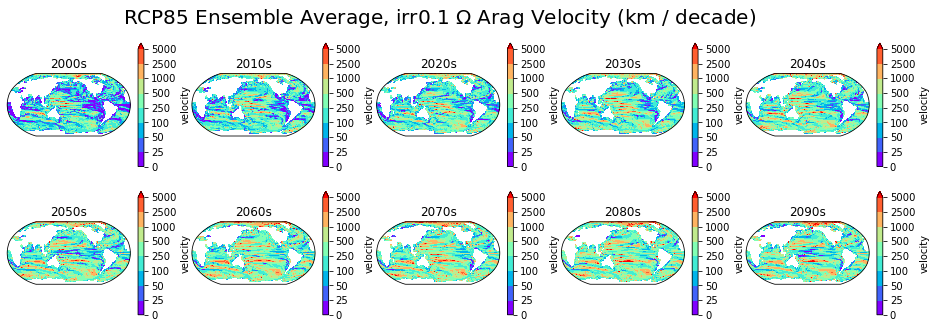

In [24]:
# Plot Omega Arag velocity magnitude (km/decade) for each decade
nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,5],
                               subplot_kw={'projection':crs})
decade = 2000
for row in range(nrows):
    for col in range(ncols):
        clevs = [0,25,50,100,250,500,1000,2500,5000]
        ax = axs[row,col]
        velocity[row*5 + col].plot(ax=ax, levels=clevs, cmap='rainbow',
                      transform=src, robust=True)
        ax.set_title(str(decade)+'s')
        decade+=10
        
fig.suptitle('RCP85 Ensemble Average, irr0.1 $\Omega$ Arag Velocity (km / decade)',
             fontsize=20)
fig.savefig("./oa_vel_10figs/oa_vel_decadal_10")

### Latitudinal Mean Velocity

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/

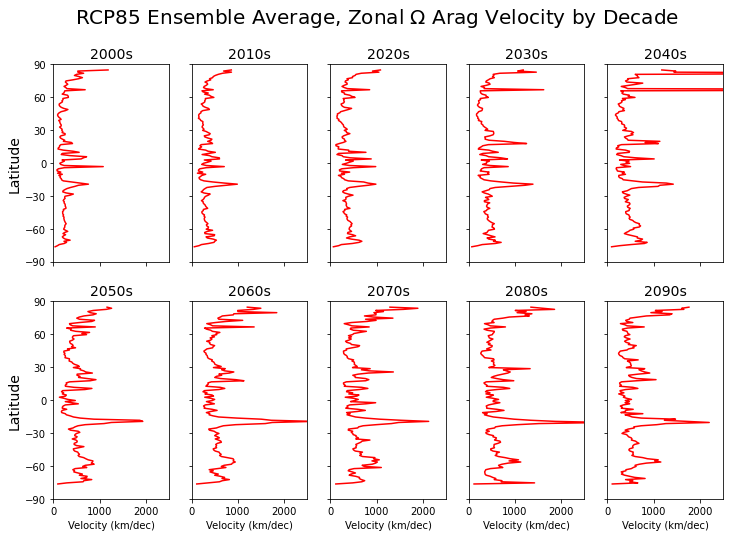

In [23]:
# Plot latitudinal mean irr0.1 Omega Arag Velocity
crs = ccrs.Robinson(central_longitude=180)
nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,8], 
                        sharex=True, sharey=True)

decade = 2000
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        i = row*5 + col
        X = velocity[i].mean(dim='xt_ocean', skipna=True).squeeze()[5:175]
        Y = velocity[i]['yt_ocean'][5:175]
        ax.plot(X,Y,'r')
        ax.set_title(str(decade)+'s',fontsize=14)
        ax.set_ylim(-90,90)
        ax.set_xlim(0, 2.5e3)
        ax.set_ylabel('Latitude',fontsize=14)
        ax.set_xlabel('Velocity (km/dec)')
        ax.set_yticks(np.arange(-90,91,30))
        ax.set_xticks(np.arange(0,2001,1000))
        # Only label outer axes
        ax.label_outer()
#         ax.ticklabel_format(axis='x', style='sci', scilimits=[0,0])

        decade += 10

fig.suptitle('RCP85 Ensemble Average, Zonal $\Omega$ Arag Velocity by Decade', 
             fontsize=20)
fig.savefig("./oa_vel_10figs/oa_vel_stats_10")